# Import files

In [3]:
from Strats.PairTradingStrat import *
from Strats.RegressionStrat import *

from PnL_Metrics.PortfolioMetrics import *
from PnL_Metrics.WRC import *
from PnL_Metrics.Backtest import *

import warnings

warnings.filterwarnings("ignore")

# Run Strats

In [2]:
# Get all available tickers
response = requests.get(f"{BASE_URL}/ticker/price")
data = response.json()
BTC_pairs = [i["symbol"] for i in data if "BTC" in i["symbol"]]


In [ ]:
# test_pairs = coint_pairs[:4]
test_cons = ['BTCUSDT', 'ETHUSDT']
print(test_cons)

symbol_manager = BinanceSymbolManager()
# Add symbols
for t in test_cons:
    print(symbol_manager.add_symbol(t))  # Success

price_fetcher = BinancePriceFetcher(symbol_manager.get_symbols())
# Fetch pair historical price
portfolio_prices = price_fetcher.get_grp_historical_ohlcv(
        interval="5m",
        start_date="2024-07-01",
        end_date="2025-05-31"
    )

portfolio_prices

['BTCUSDT', 'ETHUSDT']
'BTCUSDT' added successfully.
'ETHUSDT' added successfully.


,timestamp,BTCUSDT,ETHUSDT
0,2024-07-01 00:00:00,62722.08,3437.02
1,2024-07-01 00:05:00,62648.49,3433.81
2,2024-07-01 00:10:00,62624.00,3435.74
3,2024-07-01 00:15:00,62682.02,3438.27
4,2024-07-01 00:20:00,62674.01,3438.29
...,...,...,...
96188,2025-05-30 23:40:00,103802.36,2518.88
96189,2025-05-30 23:45:00,104067.40,2527.38
96190,2025-05-30 23:50:00,104010.45,2528.39
96191,2025-05-30 23:55:00,103985.48,2531.34


In [2]:
test_cons = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT']
portfolio_prices = pd.DataFrame()
for con in test_cons:
    data = pd.read_csv(f'RawData/{con}.csv')[['Open Time', 'Close']]
    data.columns = ['timestamp', con]
    if len(portfolio_prices) == 0:
        portfolio_prices = data.copy()
    else:
        portfolio_prices = pd.merge(portfolio_prices, data.copy(), on=['timestamp'])
portfolio_prices

,timestamp,BTCUSDT,ETHUSDT,BNBUSDT
0,2019-12-01 00:00:00+00:00,7532.23,151.00,15.6747
1,2019-12-01 00:05:00+00:00,7524.46,150.65,15.6408
2,2019-12-01 00:10:00+00:00,7504.25,150.51,15.6065
3,2019-12-01 00:15:00+00:00,7496.00,150.33,15.5783
4,2019-12-01 00:20:00+00:00,7500.42,150.63,15.6063
...,...,...,...,...
514767,2025-05-09 23:40:00+00:00,102930.16,2339.20,665.6700
514768,2025-05-09 23:45:00+00:00,102948.97,2341.92,666.5100
514769,2025-05-09 23:50:00+00:00,102972.00,2342.65,666.6700
514770,2025-05-09 23:55:00+00:00,102971.99,2345.04,666.2900


In [6]:
portfolio_prices=portfolio_prices[portfolio_prices['timestamp'] >= '2024-07-01'].reset_index(drop=True)
portfolio_prices

,timestamp,BTCUSDT,ETHUSDT,BNBUSDT
0,2024-07-01 00:00:00+00:00,62722.08,3437.02,582.00
1,2024-07-01 00:05:00+00:00,62648.49,3433.81,580.60
2,2024-07-01 00:10:00+00:00,62624.00,3435.74,580.40
3,2024-07-01 00:15:00+00:00,62682.02,3438.27,581.00
4,2024-07-01 00:20:00+00:00,62674.01,3438.29,581.30
...,...,...,...,...
81116,2025-05-09 23:40:00+00:00,102930.16,2339.20,665.67
81117,2025-05-09 23:45:00+00:00,102948.97,2341.92,666.51
81118,2025-05-09 23:50:00+00:00,102972.00,2342.65,666.67
81119,2025-05-09 23:55:00+00:00,102971.99,2345.04,666.29


In [55]:
import numpy as np
import pandas as pd
from sklearn.linear_model import (
    LinearRegression, 
    TheilSenRegressor, 
    HuberRegressor, 
    RANSACRegressor
)
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from Utils.Hurst import *

class RegressionStrat:
    """
    A trading strategy that uses different robust regression techniques to generate long/short signals.
    
    Parameters:
    -----------
    lookback_window : int
        Number of periods to use for training the regression models
    regression_type : str
        Type of regression to use ('linear', 'theilsen', 'huber', 'ransac')
    z_score_threshold : float
        Threshold for z-score of prediction error to trigger trades
    volatility_scaling : bool
        Whether to scale position sizes by recent volatility
    """
    
    def __init__(self, df, tickers, lookback_window=63, regression_type='theilsen'):
        self.df = df
        self.tickers = tickers
        self.lookback_window = lookback_window
        self.regression_type = regression_type.lower()
        
        # Initialize models
        self.models = {
            'linear': LinearRegression(),
            'theilsen': TheilSenRegressor(random_state=42),
            'huber': HuberRegressor(),
            'ransac': RANSACRegressor(random_state=42)
        }
        
        # State variables
        self.current_position = 0
        self.holding_counter = 0
        self.prediction_error_history = []
        self.scaler = StandardScaler()
        
    def _get_features_targets(self, t):
        """Create feature matrix (lags) and target vector (future returns)"""
        returns = self.df[t].pct_change()

        # Create lagged features
        df_preprocessed = pd.DataFrame()
        for lag in range(1, self.lookback_window, 1000):
            df_preprocessed[f'lag_{lag}'] = returns.shift(lag)
        
        df_preprocessed['rolling_vol'] = returns.rolling(window=self.lookback_window).std().shift(1)
        
        df_preprocessed[t] = returns
        # Align and drop NA
        df_preprocessed = df_preprocessed.dropna().reset_index(drop=True)
        X, y = df_preprocessed.drop(columns=[t]), df_preprocessed[t]
        
        return X, y
    
    
    def _get_model(self):
        """Get the appropriate regression model based on type"""
        if self.regression_type not in self.models:
            raise ValueError(f"Unknown regression type: {self.regression_type}. "
                           f"Available options: {list(self.models.keys())}")
        return self.models[self.regression_type]
    
    def _get_position_size(self, prediction_error_z, volatility):
        """Determine position size based on prediction error and volatility"""
        # Base position size based on z-score
        position_size = np.clip(prediction_error_z / self.z_score_threshold, -1, 1)
        
        # Scale by volatility if enabled
        if self.volatility_scaling and volatility > 0:
            position_size /= volatility
            
        return position_size
    
    def generate_signals(self, pca_components=3, threshold=1):
        pipeline = Pipeline([('scaler', StandardScaler()),
                             ('PCA', PCA(n_components=min(pca_components, self.lookback_window))),
                             ('model', self._get_model())])
        
        for t in self.tickers:
            X, y = self._get_features_targets(t)
            preds = [0] * self.lookback_window
            is_trend = [0] * self.lookback_window
            for i in tqdm(range(self.lookback_window, len(self.df), self.lookback_window)):
                X_temp, y_temp = X[i-self.lookback_window: i], y[i-self.lookback_window: i]
                try:
                    pipeline.fit(X_temp, y_temp)
                except:
                    try:
                        pred_price = pipeline.predict(X[i:i+self.lookback_window])
                    except:
                        return X[i:i+self.lookback_window]

                pred_price = pipeline.predict(X[i:i+self.lookback_window])
                preds += list(pred_price)

                if hurst_exponent(self.df[t][i-self.lookback_window:i].values) > 0.7:
                    is_trend += [1]
                else:
                    is_trend += [0]
            
            preds = np.array(preds)[:len(self.df)]
            self.df[t+'_signal'] = np.where(preds < -threshold, -1, 0)
            self.df[t+'_signal'] = np.where(preds > threshold, 1, self.df[t+'_signal'])
            self.df[t+'_exit_signal'] = is_trend[:len(self.df)]

        return self.df

    

In [56]:
lr_model = RegressionStrat(portfolio_prices.copy(), test_cons, lookback_window=10000, regression_type='theilsen')
lr_signals = lr_model.generate_signals(pca_components=3, threshold=1)
lr_signals

 88%|████████▊ | 7/8 [00:33<00:04,  4.74s/it]


ValueError: Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required by StandardScaler.

In [ ]:
model = pair_trading(portfolio_prices.copy())
spread = model.generate_signals(lookback=8640, execute_threshold=1.5, close_threshold=0.7)
spread

In [ ]:
test_start_date, test_end_date = "2024-12-01", "2025-05-31"

In [ ]:
stoploss = 0.05
drawdown_duration = 2880
rolling=1000
weight_method=inverse_volatility_weighting
short = False

mr_backtest = Backtest(spread.copy(), tickers = test_cons, test_start_date=test_start_date, test_end_date=test_end_date, stoploss=stoploss, drawdown_duration=drawdown_duration)
mr_pnl_df = mr_backtest.computePortfolioPnL(rolling=rolling, weight_method=weight_method, allow_short=short)
mr_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-12-01 00:00:00,0.000000,0.000000
1,2024-12-01 00:05:00,-0.000032,-0.000032
2,2024-12-01 00:10:00,-0.000496,-0.000496
3,2024-12-01 00:15:00,0.000000,-0.000496
4,2024-12-01 00:20:00,0.000060,-0.000436
...,...,...,...
52124,2025-05-30 23:40:00,0.000000,14621.105168
52125,2025-05-30 23:45:00,0.000000,14621.105168
52126,2025-05-30 23:50:00,0.000000,14621.105168
52127,2025-05-30 23:55:00,0.000000,14621.105168


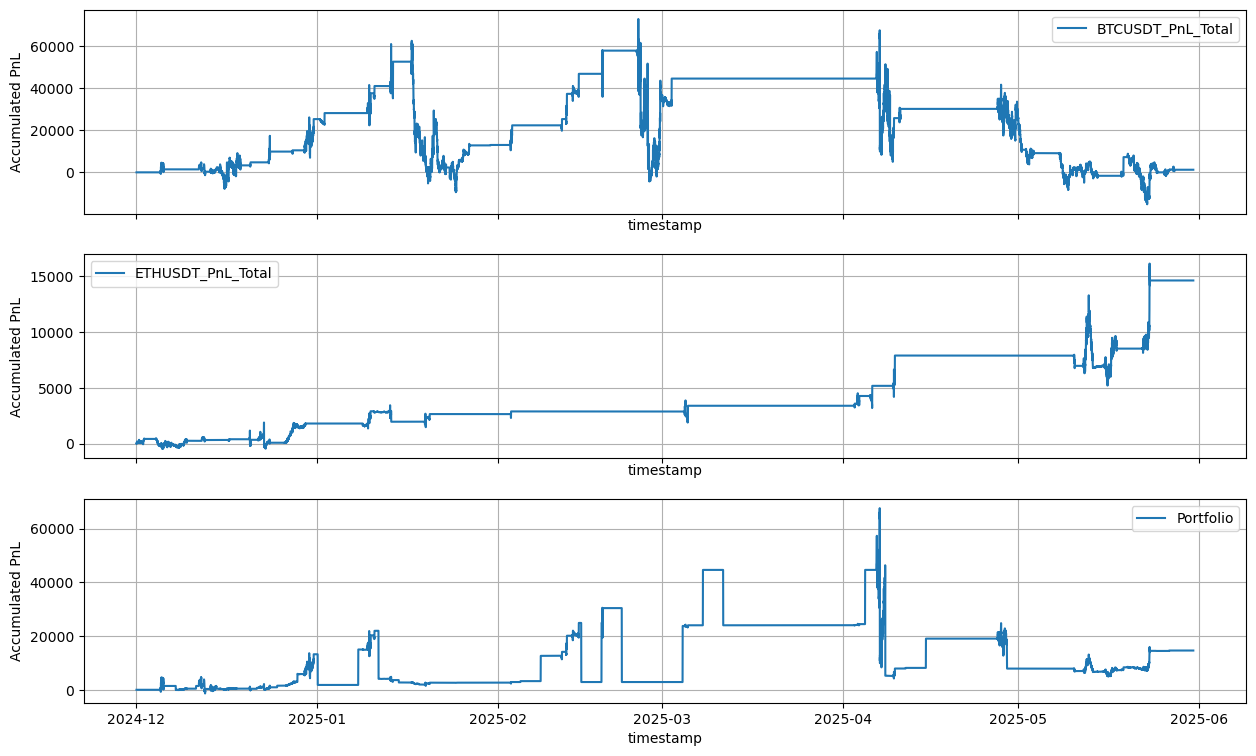

In [ ]:
mr_backtest.plot_pnl(rolling=rolling, weight_method=weight_method, allow_short=short)

In [ ]:
simple_strat = SimpleStrat(data=portfolio_prices)
simple_df = simple_strat.simple_strategy(lookback=12*24*3, hold_period=12*24*3)

In [ ]:
simple_backtest = Backtest(simple_df.copy(), tickers = test_cons, test_start_date=test_start_date, test_end_date=test_end_date, stoploss=stoploss, drawdown_duration=drawdown_duration)
simple_pnl_df = simple_backtest.computePortfolioPnL(rolling=rolling, weight_method=weight_method, allow_short=short)
simple_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-12-01 00:00:00,0.000000,0.000000
1,2024-12-01 00:05:00,-0.004249,-0.004249
2,2024-12-01 00:10:00,0.034705,0.034705
3,2024-12-01 00:15:00,0.000000,0.034705
4,2024-12-01 00:20:00,0.000000,0.034705
...,...,...,...
52124,2025-05-30 23:40:00,0.000000,109.563981
52125,2025-05-30 23:45:00,0.000000,109.563981
52126,2025-05-30 23:50:00,0.000000,109.563981
52127,2025-05-30 23:55:00,0.000000,109.563981


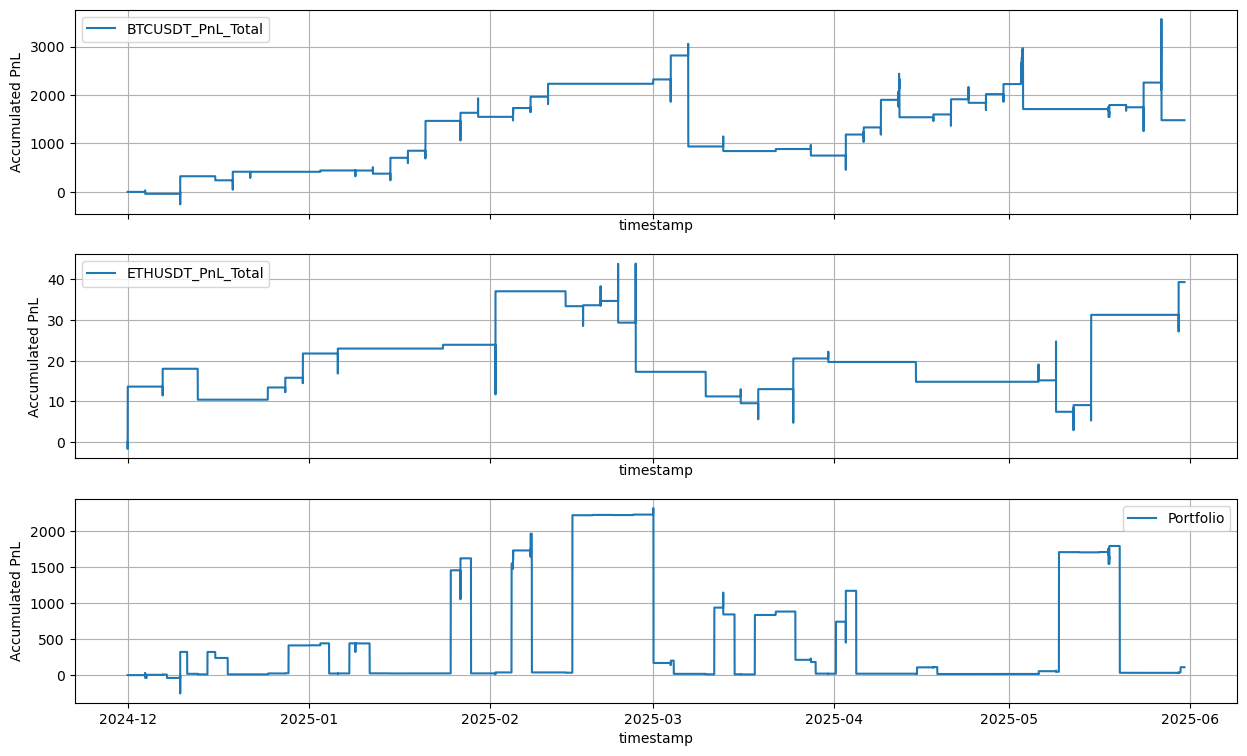

In [ ]:
simple_backtest.plot_pnl(rolling=rolling, weight_method=weight_method, allow_short=short)

# Comparison

In [ ]:
mr_returns = mr_backtest.get_returns(notional = 10e6, rolling=rolling, weight_method=weight_method, allow_short=short)
momentum_returns = simple_backtest.get_returns(notional = 10e6, rolling=rolling, weight_method=weight_method, allow_short=short)

returns = pd.DataFrame()
returns["Simple"] = momentum_returns
returns["MeanRevert"] = mr_returns

port_metrics = PortfolioMetrics(returns.dropna(), periods_per_year=252*12*24)
summary = port_metrics.summary(risk_free_rate=0)
print(summary)

            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Simple               0.000015               0.000680      0.022421   
Pair_Trade           0.001961               0.012388      0.164318   

            Max Drawdown Duration  Max Drawdown  Calmar Ratio   Skewness  \
Simple                      15131     -0.000231      0.065157  -6.219846   
Pair_Trade                  15131     -0.006347      0.308907 -36.289286   

               Kurtosis      VaR (5%)  CVaR (5%)  Tail Ratio  Omega Ratio  
Simple      4488.744072 -4.600689e-08  -0.000018    1.195785     1.007427  
Pair_Trade  4444.967148 -4.600689e-08  -0.000016    1.195785     1.017422  


In [ ]:
wrc = WhiteRealityCheck(strategies=returns["MeanRevert"], benchmark=returns["Simple"])
wrc.run()
wrc.superior_strategies()

White Reality Check Results:
p-value: lower         0.392
consistent    0.392
upper         0.392
dtype: float64
Superior strategy indices:
[]


[]